# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Vamos analisar os dados apresentados pela Loggi, uma empresa consolidada na área da logistíca. Os dados consistem em informações sobre entregas realizadas no Distrito Federal, porém eles estão sendo fornecidos no formato JSON e o nosso trabalho será:



*   Explorar os dados:

  Primeiramente, vamos transformá-los em um DataFrame. A ideia é poder manipular os dados com mais facilidade, pois nesse formato possuimos diversas ferramentas que nos auxiliarão na exclusão de dados não necessários, ordena-los em colunas, relizar operações dentro dessas colunas...
*   Manipulação:

  Com os dados estruturados, podemos manipula-los. Aqui, nossa intenção é realizar uma exploração mais profunda, onde iremos selecionar as colunas de interesse e procuraremos enriquece-las para gerar bases sólidas para a etapa de visualização.


*   Visualização:

  Após as etapas de eploração e manipulação, os dados estarão prontos para serem visualizados. Essa etapa é extremamente importante, pois com essas informações geraremos insghts que auxiliarão na logística das entregas.







---



## 2\. Pacotes e bibliotecas


Aqui vamos baixar todas as bibliotecas que serão necessárias para a resolução do problema.

In [ ]:
# importando bibliotecas

import json
import pandas as pd

import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import numpy as np

import seaborn as sns

import geopandas

import matplotlib.pyplot as plt

!pip3 install geopandas;



---



## 3\. Exploração de dados

Nesta etapa, vamos processar o dado bruto(arquivo tipo JSON com o nome de delivieres.json) em um DataFrame e realizar algumas operações. Esse arquivo possui algumas instâncias de entrega, onde cada instância representa uma entrega que deve ser realizada.
Utilizando dos nossos conhecimentos de data wrangling, vamos manipular as informações de interesse, e uma das principais é corrigir os tipos de dados que estão presentes em algumas colunas. Realizaremos algumas operações de achatamento(flatten) para normalizar os dados que estão aninhados(nested).

In [ ]:
# download do dado bruto:

!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

# abrindo-o no modo de leitura, salvando numa variável chamada data e criando um DataFrame com o nome de deliveries_df:

with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

deliveries_df = pd.DataFrame(data)

# normalizando a coluna ['origin'], juntando os DataFrame criados e renomeando o nome de algumas colunas:

hub_origin_df = pd.json_normalize(deliveries_df['origin'])

deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop('origin', axis=1)
deliveries_df = deliveries_df[['name', 'region', 'lng', 'lat', 'vehicle_capacity', 'deliveries']]
deliveries_df.rename(columns={'lng': 'hub_lng', 'lat': 'hub_lat'}, inplace=True)

# a coluna ['deliveries'] está um pouco mais complexa, para isso vamos realizar primeiro uma operação chama (explode) e depois normalizá-la:

deliveries_explode_df = deliveries_df[['deliveries']].explode('deliveries')

deliveries_normalize_df = pd.concat([
    pd.DataFrame(deliveries_explode_df['deliveries'].apply(lambda record: record['size'])).rename(columns={'deliveries': 'delivery_size'}),
    pd.DataFrame(deliveries_explode_df['deliveries'].apply(lambda record: record['point']['lng'])).rename(columns={'deliveries': 'delivery_lng'}),
    pd.DataFrame(deliveries_explode_df['deliveries'].apply(lambda record: record['point']['lat'])).rename(columns={'deliveries': 'delivery_lat'}),
], axis=1)
deliveries_df = deliveries_df.drop('deliveries', axis=1)

deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalize_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df.head()


,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055




*   Agora vamos conhecer melhor um pouco a estrutura do nosso DataFrame:


In [ ]:
# com os dados corrigidos, vamos ver quantas linhas e colunas tem o nosso novo arquivo:

deliveries_df.shape

(636149, 8)

In [ ]:
# os nomes da nossa nova coluna:

deliveries_df.columns

Index(['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity',
       'delivery_size', 'delivery_lng', 'delivery_lat'],
      dtype='object')

In [ ]:
# os tipos de dados de cada coluna:

deliveries_df.dtypes

name                 object
region               object
hub_lng             float64
hub_lat             float64
vehicle_capacity      int64
delivery_size         int64
delivery_lng        float64
delivery_lat        float64
dtype: object

In [ ]:
# uma visão geral:

deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB




---



## 4\. Manipulação

Após a etapa de exploração, podemos seguir para a etapa de manipulação dos dados. E aqui, vamos começar a separar os dados que nos interessam(como colunas de interesse e renomeação para uma melhor interpretação dos dados) e aplicar algumas funções que servirão como base para etapa de visualização, como os comandos de geolocazição.


In [ ]:
# separando as colunas de interesse para realizarmos a geocodificação reversa:

hub_df = deliveries_df[['region', 'hub_lng', 'hub_lat']]
hub_df = hub_df.drop_duplicates().sort_values(by='region').reset_index(drop=True)

geolocator = Nominatim(user_agent='ebac_geocoder')
location = geolocator.reverse('-15.657013854445248, -47.802664728268745')

geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)


* Aplicando a geocodificação para extrairmos as informações referentes a cidade e bairro:



In [ ]:
hub_df['coordinates'] = hub_df['hub_lat'].astype(str) + ',' + hub_df['hub_lng'].astype(str)
hub_df['geodata'] = hub_df['coordinates'].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248,-47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334,-47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274,-48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [ ]:
hub_geodata_df = pd.json_normalize(hub_df['geodata'].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.00001,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8




*   Selecionando e renomeando as colunas de interesse:



In [ ]:
hub_geodata_df = hub_geodata_df[['address.town', 'address.suburb', 'address.city']]
hub_geodata_df.rename(columns={'address.town': 'hub_town', 'address.suburb': 'hub_suburb', 'address.city': 'hub_city'}, inplace= True)
hub_geodata_df['hub_city'] = np.where(hub_geodata_df['hub_city'].notna(), hub_geodata_df['hub_city'], hub_geodata_df['hub_town'])
hub_geodata_df['hub_suburb'] = np.where(hub_geodata_df['hub_suburb'].notna(), hub_geodata_df['hub_suburb'], hub_geodata_df['hub_city'])
hub_geodata_df = hub_geodata_df.drop('hub_town', axis=1)
hub_geodata_df.head()

<ipython-input-10-034d2673b60e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df.rename(columns={'address.town': 'hub_town', 'address.suburb': 'hub_suburb', 'address.city': 'hub_city'}, inplace= True)
<ipython-input-10-034d2673b60e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df['hub_city'] = np.where(hub_geodata_df['hub_city'].notna(), hub_geodata_df['hub_city'], hub_geodata_df['hub_town'])
<ipython-input-10-034d2673b60e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga




*   inserindo os dados corrigidos nas DataFrames hub_df e deliveries_df:



In [ ]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


*   Aplicando a geocodificação reversa da entrega



**Obs**: Os dados estão sendo passados através do link abaixo

In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [ ]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol




---



## 5\. Visualização

Após as etapas de extração, manipulação e enriquecimento do código, vamos visualizar as informações e gerar insights sobre possíveis possibilidades.

O primeiro gráfico a ser gerado será sobre uma análise a respeito da quantidade total das entregas realizadas em cada seção. Com isso poderemos ver se há discrepâncias ou similaridades, e gerar bases para outros estudos e análises.

In [ ]:
#Criando um DataFrame com as informações sobre as entregas para cada região

novo_hub_df = deliveries_df['region'].value_counts().reset_index()
novo_hub_df.columns = ['regiao', 'entregas']
novo_hub_df.head()

,regiao,entregas
0,df-1,304708
1,df-2,261319
2,df-0,70122


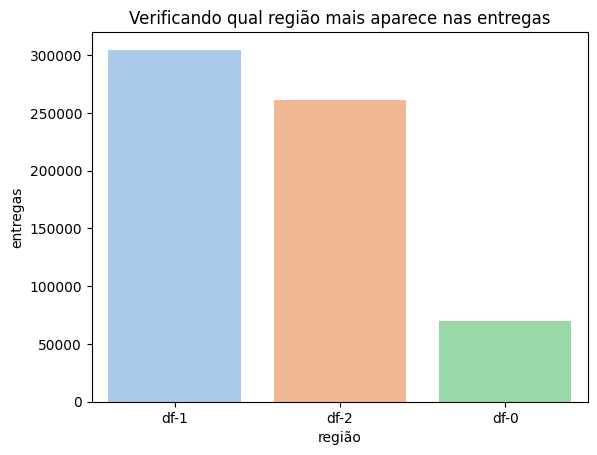

In [ ]:
#Montando um gráfico com a relação de entregas por região

grafico = sns.barplot(data=novo_hub_df, x='regiao', y='entregas', errorbar=None, hue='regiao', palette='pastel')
grafico.set(title='Verificando qual região mais aparece nas entregas', xlabel='região');

Analisando os dados apresentados no gráfico, observamos que as regiões correspondentes ao DF-1 e DF-2 possuem um grande volume de entregas. Sendo apresentada em cada uma, quantidades superiores a 250.000 encomendas. Já a área correspondente ao DF-0, possui um baixo volume de entregas.
Diante disso, poderíamos analisar quais motivos incluenciam nessa discrepância entre os setores, como: o tamanho da área que corresponde ao DF-0 em comparação aos demais, quantidade de pessoas, se é uma área de difícil acesso... Com essas informações em mãos, poderíamos traçar estratégias sobre como alavancar o número de encomendas nessa região ou remanejar parte do excedente da força de trabalho para os outros setores.



---



Agora, vamos realizar a visualização geoespacial para entender um pouco melhor as informações apresentadas anteriormente.



*   Vamos agora instalar o geopandas para auxiliar na visualização geoespacial das coordenadas dos **hub** e **entregas**.



In [ ]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [ ]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


Mapa dos hub

In [ ]:
hub_df = deliveries_df[['region', 'hub_lng', 'hub_lat']].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df['hub_lng'], hub_df['hub_lat']))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


Mapa das entregas

In [ ]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df['delivery_lng'], deliveries_df['delivery_lat']))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


visualização

<ipython-input-22-d9ef8180ec35>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


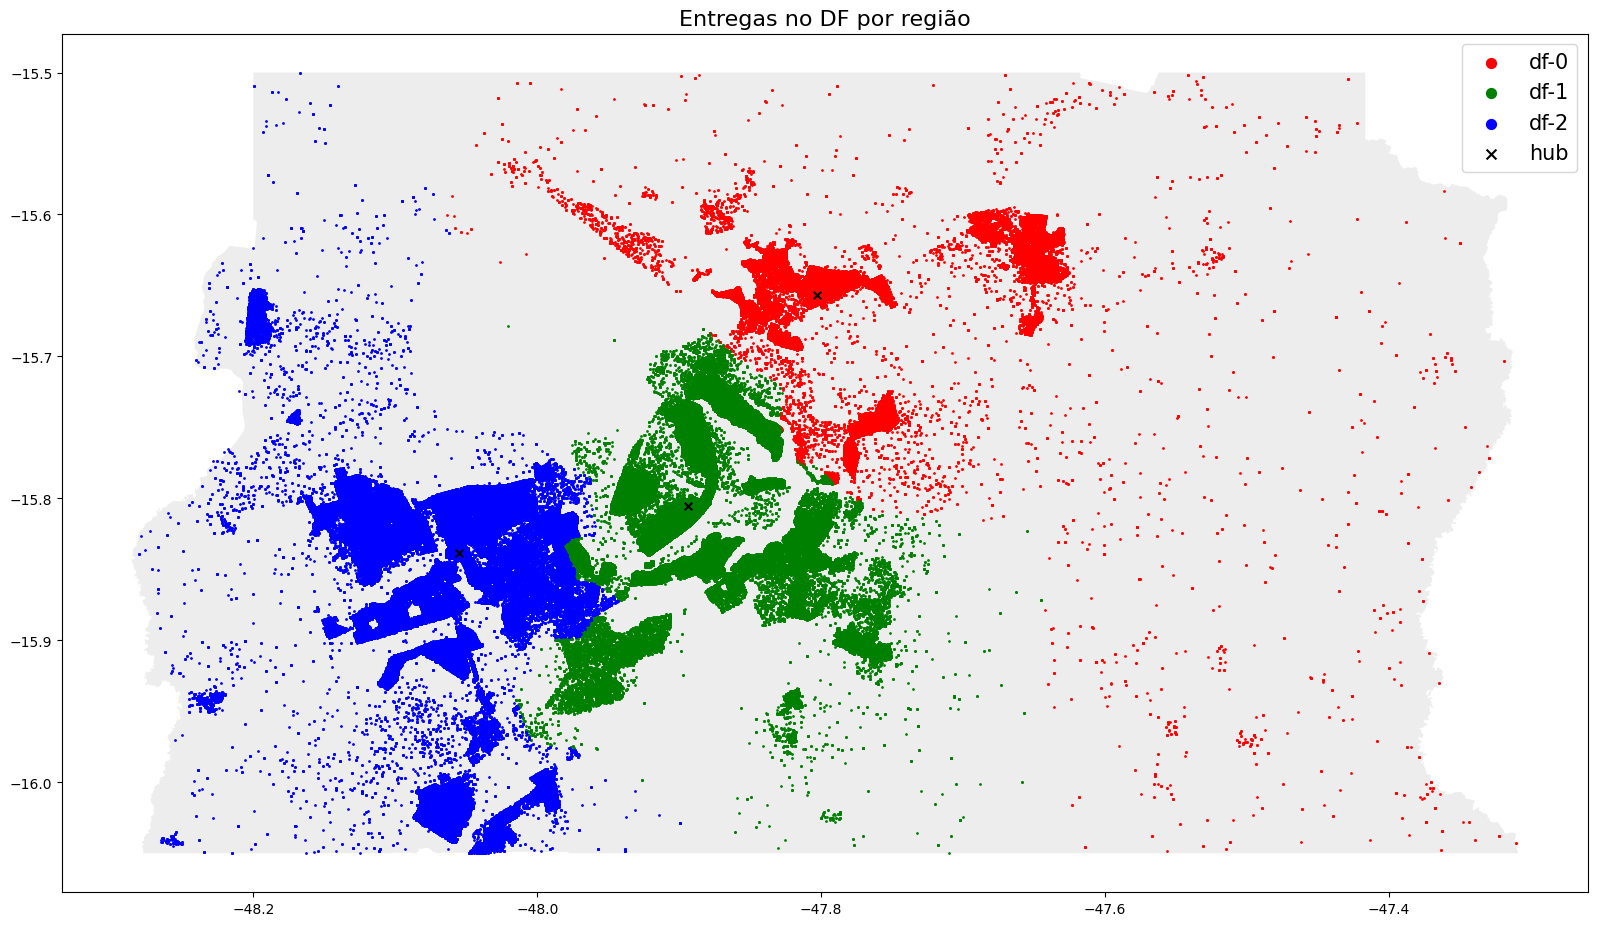

In [ ]:
#criando o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

#plot mapa do df
mapa.plot(ax=ax, alpha=0.4, color='lightgrey')

#plot das entregas
geo_deliveries_df.query(" region == 'df-0'").plot(ax=ax, markersize=1, color="red", label='df-0')
geo_deliveries_df.query(" region == 'df-1'").plot(ax=ax, markersize=1, color="green", label='df-1')
geo_deliveries_df.query(" region == 'df-2'").plot(ax=ax, markersize=1, color="blue", label='df-2')

#plot dos hub
geo_hub_df.plot(ax=ax, markersize=30, marker='x', color='black', label='hub')

#plot da legenda
plt.title('Entregas no DF por região', fontdict={'fontsize':16})
lgnd = plt.legend(prop={'size':15})
for handle in lgnd.legendHandles:
  handle.set_sizes([50])

Nessa representação geoespacial das entregas podemos confirmar o que foi passado no gráfico anterior. Tendo as áreas de entrtegas referentes às zonas DF-1 e DF=2 concentrando boa parte das entregas.

Já o DF-0, possui boa parte de suas entregas próximas ao ponto de distribuição. O que pode nos sugerir que tal localização se encontra próximo as zonas comerciais ou residênciais.



*   Agora vamos analisar a distribuição dos pesos das encomendas em cada zona de entrega.



In [ ]:
#Selecionando as colunas de interesse

size_deliveries = deliveries_df[['region', 'delivery_size']]
size_deliveries.head()

,region,delivery_size
0,df-2,9
1,df-2,2
2,df-2,1
3,df-2,2
4,df-2,7


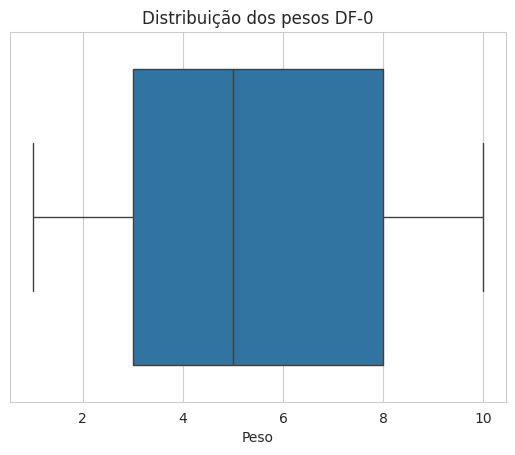

In [ ]:
#Criando o gráfico em relação ao DF-0

size_deliveries_df0 = size_deliveries.query("region == 'df-0'")

with sns.axes_style('whitegrid'):
  grafico = sns.boxplot(x=size_deliveries_df0['delivery_size'])
  grafico.set(title='Distribuição dos pesos DF-0', xlabel='Peso')

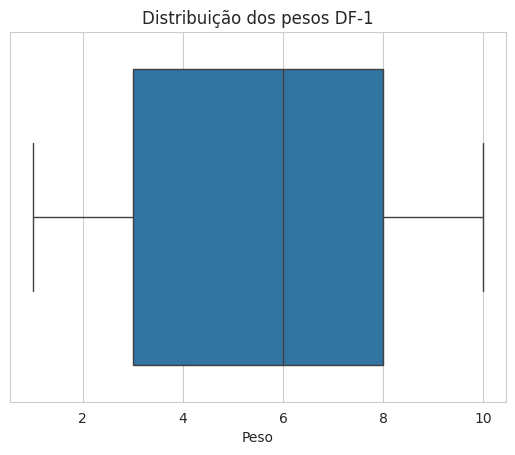

In [ ]:
#Criando o gráfico em relação ao DF-1


size_deliveries_df1 = size_deliveries.query("region == 'df-1'")

with sns.axes_style('whitegrid'):
  grafico = sns.boxplot(x=size_deliveries_df1['delivery_size'])
  grafico.set(title='Distribuição dos pesos DF-1', xlabel='Peso')

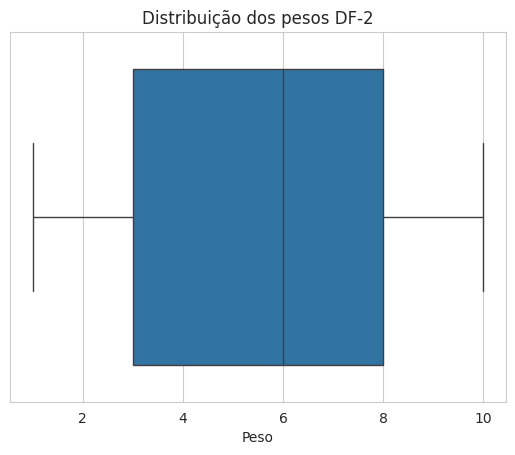

In [ ]:
#Criando o gráfico em relação ao DF-2


size_deliveries_df2 = size_deliveries.query("region == 'df-2'")

with sns.axes_style('whitegrid'):
  grafico = sns.boxplot(x=size_deliveries_df2['delivery_size'])
  grafico.set(title='Distribuição dos pesos DF-2', xlabel='Peso')

Com a utilização do gráfico **Box Plot** podemos observar que a média dos pesos das encomendas são iguais nos DF-1 e DF-2, porém essa média sofre uma pequena redução se comparado ao DF-0.

Diante disso, podemos sugerir que além do DF-0 possuir uma menor quantidade de entregas, as proprias entregas são em média mais leves. O que poderia nos ajudar na reorganização dos carros, talvez substituindo os veículos utilizados no DF-0 por moto, ou veiculos mais leves.

